In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

In [26]:
sns.set_style('darkgrid')

In [3]:
!kaggle competitions download -c advanced-dls-spring-2021

100%|█████████████████████████████████████████| 115k/115k [00:00<00:00, 855kB/s]
100%|█████████████████████████████████████████| 115k/115k [00:00<00:00, 850kB/s]


In [ ]:
!unzip advanced-dls-spring-2021.zip -d data

Archive:  advanced-dls-spring-2021.zip
  inflating: data/submission.csv     
  inflating: data/test.csv           
  inflating: data/train.csv          


In [8]:
!rm advanced-dls-spring-2021.zip

In [21]:
data = pd.read_csv('./data/train.csv')
data.head(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [22]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [23]:
data.replace(" ", np.nan, inplace=True)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5273 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5273 non-null   int64  
 1   MonthlySpending           5273 non-null   float64
 2   TotalSpent                5273 non-null   object 
 3   Sex                       5273 non-null   object 
 4   IsSeniorCitizen           5273 non-null   int64  
 5   HasPartner                5273 non-null   object 
 6   HasChild                  5273 non-null   object 
 7   HasPhoneService           5273 non-null   object 
 8   HasMultiplePhoneNumbers   5273 non-null   object 
 9   HasInternetService        5273 non-null   object 
 10  HasOnlineSecurityService  5273 non-null   object 
 11  HasOnlineBackup           5273 non-null   object 
 12  HasDeviceProtection       5273 non-null   object 
 13  HasTechSupportAccess      5273 non-null   object 
 14  HasOnlineTV  

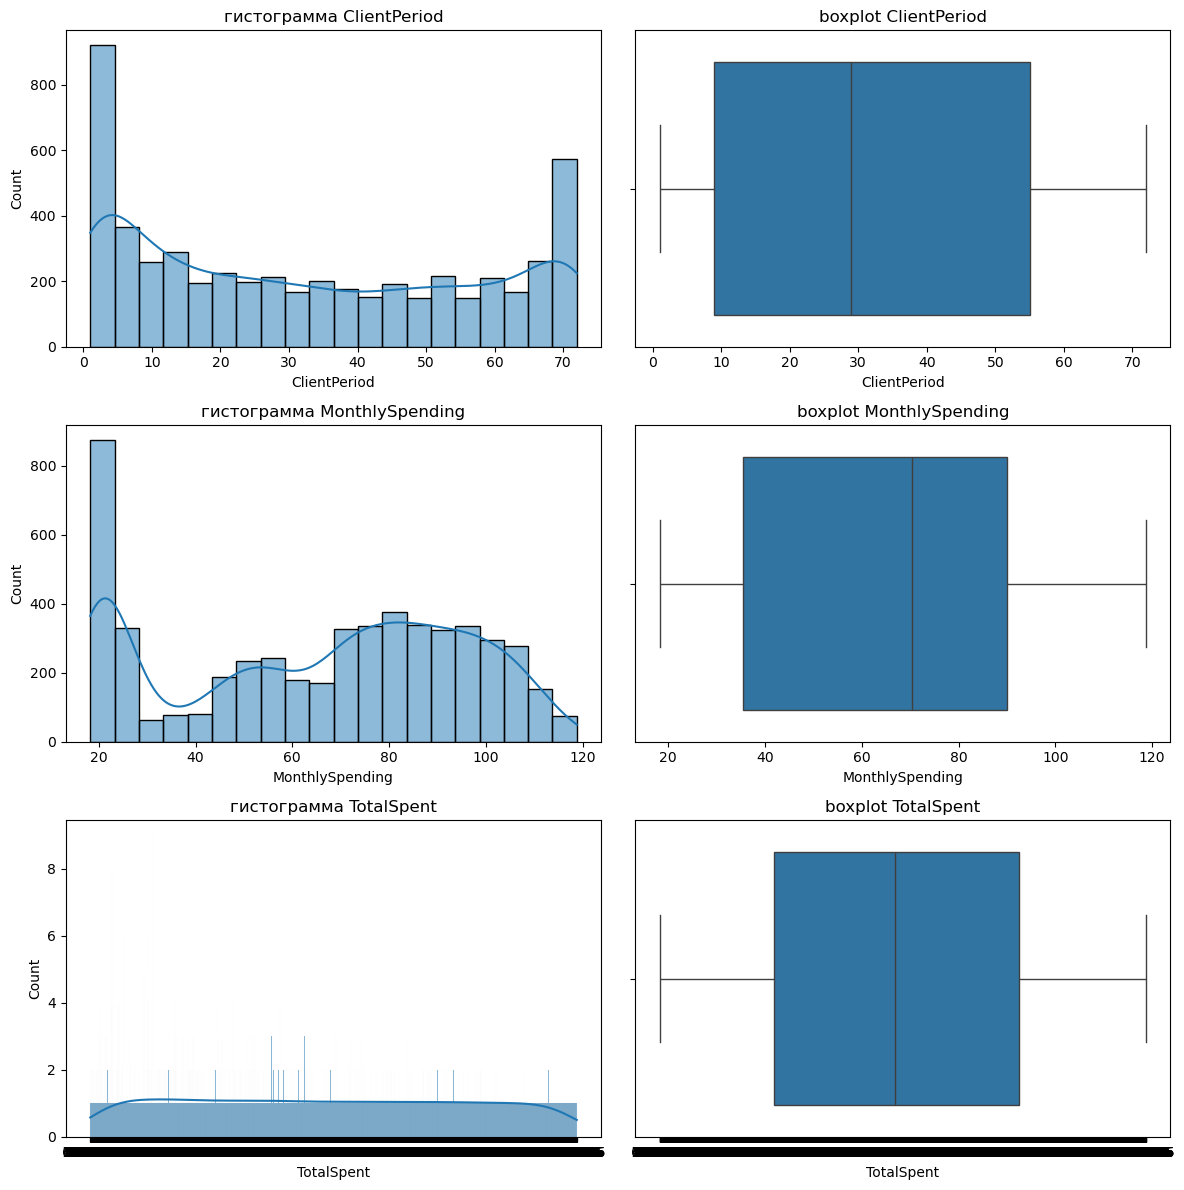

In [24]:
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.histplot(data[col], bins=20, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'гистограмма {col}')
    sns.boxplot(x=data[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'boxplot {col}')

plt.tight_layout()
plt.show()

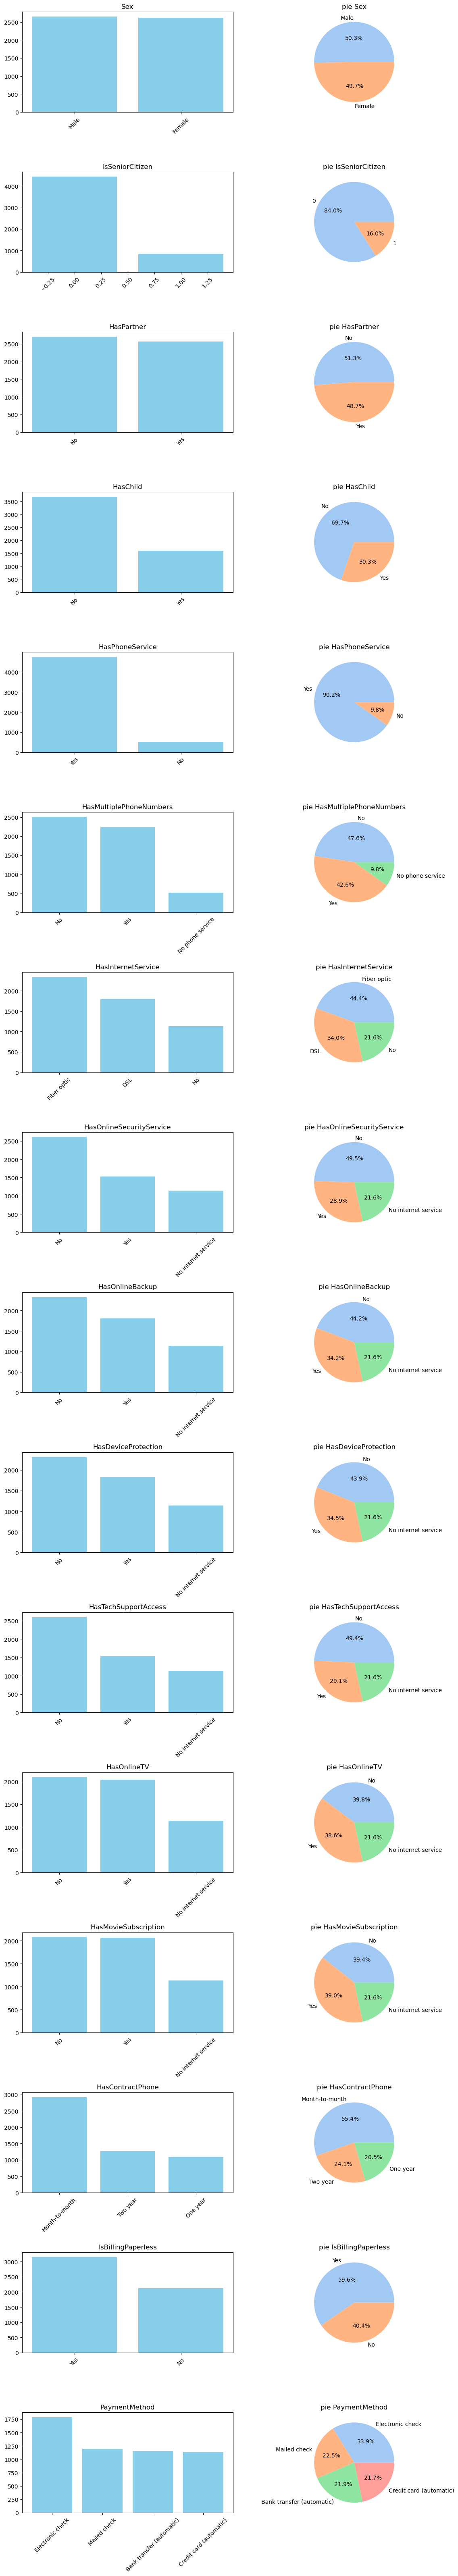

In [25]:
fig, axes = plt.subplots(len(cat_cols), 2, figsize=(12, 4 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    value_counts = data[col].value_counts()

    axes[i, 0].bar(value_counts.index, value_counts.values, color='skyblue')
    axes[i, 0].set_title(f'{col}')
    axes[i, 0].tick_params(axis='x', rotation=45)

    axes[i, 1].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    axes[i, 1].set_title(f'pie {col}')

plt.tight_layout()
plt.show()

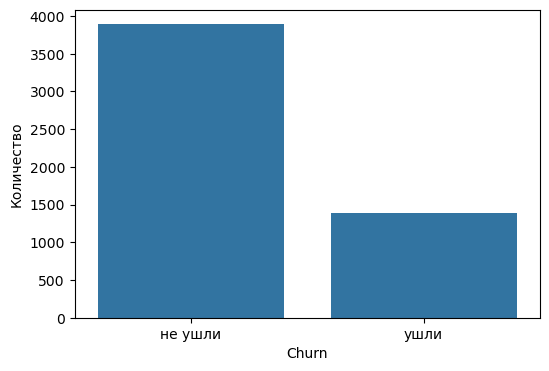

доля клиентов, которые ушли: 26.25%


In [26]:
churn_counts = data['Churn'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.ylabel("Количество")
plt.xticks([0, 1], ["не ушли", "ушли"])
plt.show()

churn_ratio = churn_counts[1] / churn_counts.sum()
print(f"доля клиентов, которые ушли: {churn_ratio:.2%}")


In [27]:
X = data.drop(columns=['Churn'])
y = data['Churn']


In [28]:
label_encoders = {col: LabelEncoder() for col in cat_cols}
for col in cat_cols:
    X[col] = label_encoders[col].fit_transform(X[col])

In [29]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [31]:
log_reg_cv = make_pipeline(preprocessor, LogisticRegressionCV(Cs=[100, 10, 1, 0.1, 0.01, 0.001],
                                                              cv=5, scoring='roc_auc', refit=True, random_state=42))
log_reg_cv.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                                                   'HasTechSupportAccess',
                                                   'HasOnlineTV',
                                                   'HasMovieSubscription',
                                                   'HasContractPhone',
                                                   'IsBillingPaperless',
                                                   'PaymentMethod'])])),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=[100, 10, 1, 0.1, 0.01, 0.001], cv=5,
                                      random_state=42, scoring='roc_auc'))])

In [32]:
y_pred_proba = log_reg_cv.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'roc auc на тесте: {roc_auc:.4f}')

roc auc на тесте: 0.8514


In [33]:
param_grid = {'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001]}

pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=42))
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', refit=True)
grid_search.fit(X_train, y_train)

y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'roc auc на тесте: {roc_auc:.4f}')

roc auc на тесте: 0.8509


In [34]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
data['TotalSpent'].fillna(data['TotalSpent'].median(), inplace=True)

X = data.drop(columns=['Churn'])
y = data['Churn']

/var/folders/1m/dzf4t3l52bb2l28wrhcwc_dr0000gn/T/ipykernel_14513/2534018542.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalSpent'].fillna(data['TotalSpent'].median(), inplace=True)


In [35]:
X = pd.get_dummies(X, columns=[
    'Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 
    'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 
    'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 
    'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 
    'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'
])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [36]:
xgb_model = XGBClassifier(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=6, 
    eval_metric='auc', 
)

xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)

y_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]

roc_auc = roc_auc_score(y_valid, y_pred_proba)


[0]	validation_0-auc:0.83192
[100]	validation_0-auc:0.83725
[200]	validation_0-auc:0.82489
[300]	validation_0-auc:0.81832
[400]	validation_0-auc:0.81488
[499]	validation_0-auc:0.81282


In [72]:
param_dist = {
    'n_estimators': [10, 20 , 100, 150, 200, 250, 300, 400, 500, 1000],
    'learning_rate': [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.5, 1],
    'max_depth': [2, 4, 6, 8, 10, 12, 16, 20, 25]
}

xgb = XGBClassifier(eval_metric='auc', tree_method='hist')

random_search = GridSearchCV(xgb, param_distributions=param_dist, 
                                   n_iter=5, scoring='roc_auc', 
                                   cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

y_pred_proba = best_model.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f'ROC-AUC: {roc_auc:.4f} с параметрами {best_params}')


TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'param_distributions'

In [86]:
param_grid = {
    'n_estimators': [400, 450, 500, 550],
    'max_depth': [2, 3, 4, 5, 6, 8, 10, 20],
    'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=52)

grid_search = GridSearchCV(
    xgb, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)

print("Лучший ROC AUC:", grid_search.best_score_)

print("Лучшие параметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 448 candidates, totalling 1344 fits
[CV] END learning_rate=0.005, max_depth=2, n_estimators=400, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=400, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=400, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=400, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=400, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=450, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=400, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=450, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=450, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.005, max_depth=2, n_estimators=450, subsample=1.0; total

In [87]:
columns_list = [
    'Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 
    'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 
    'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 
    'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 
    'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'
]

In [88]:
X_test = pd.read_csv('./data/test.csv')
X_test["TotalSpent"] = pd.to_numeric(X_test["TotalSpent"], errors='coerce').fillna(0)

X_test = pd.get_dummies(X_test, columns=columns_list)


In [89]:
submission = pd.read_csv('./data/submission.csv')
submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./data/my_submission.csv', index=False)

In [91]:
!kaggle competitions submit -c advanced-dls-spring-2021 -f data/my_submission.csv -m "Message"

100%|██████████████████████████████████████| 26.4k/26.4k [00:00<00:00, 29.1kB/s]
Successfully submitted to Предсказание оттока пользователей (весна 2021)